#**CONTENUTO DEL NOTEBOOK**
In questo script confrontiamo le visualizzazioni di LDA e PCA, 2d e 3d dov'è possibile rispetto alle differenze tra le 3 condizioni muscolari. Vengono considerati i muscoli della coscia.
> In ordine abbiamo:
* Setting per Texture analyis
* Estrazione delle features
* Creazione dei Dataframes
* MANOVA
* Perchè non si può fare LDA 3D
* LDA 2D
* PCA 3D
* features più significative
* esclusione degli outliers (mostrare solo il 99° percentile)
* Altre tecniche di dimensionality reduction (t-SNE, UMAP)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install umap-learn

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=850d4a42fcefa0e0d82432eac6e83c9d5f7749c8b964b325a4ded55c9b11da52
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=5fa542e067533e8e669637fa1d1dafb06ab86b72eaad4fd82472a3913dd9b1a4
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


In [ ]:
!pip install kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.8 MB/s eta 0:00:00


In [ ]:
!pip install pyradiomics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 555.3/555.3 KB 51.9 MB/s eta 0:00:00
  Created wheel for pyradiomics: filename=pyradiomics-3.0.1-cp38-cp38-linux_x86_64.whl size=190673 sha256=244ea6a792ed16e3fa5d9358e6e9807e43b945666b85f235c1de35e1bc68955e
  Stored in directory: /root/.cache/pip/wheels/df/be/06/5d09092e41d20673137f10ae62fb8d9da9adf14ce2552d7bea
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=f1a61d3e247f14bd808447019dbb6442d2b5459c1477f7c555dc2c242a33991c
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b

#Import funzioni utili

In [ ]:

import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
from radiomics import featureextractor
from __future__ import print_function
import os
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from glob import glob
import pandas as pd


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from statsmodels.multivariate.manova import MANOVA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

import plotly.express as px
import plotly.io as pio

#Inizializzare i parametri della texture analysis

In [ ]:
#%%============================================================================
#             INIZIALIZZARE I PARAMETRI PER LA TEXTURE ANALYSIS
#==============================================================================

"""Sulla repository di Pyradiomics in "Example_settings" c'erano i parametri consigliati 
   per immagini MR con uno spessore di 5 mm , come quelle che compongono il nostro
   Dataset, quindi ho riportato manualmente quei settings"""

settings = {}
settings['binWidth'] = 25
settings['normalize'] = True
settings['normalizeScale'] = 100
  # Resampling:
  # Increasing the resampled spacing forces PyRadiomics to look at more coarse textures, which may or
  # may not increase accuracy and stability of your extracted features. Using a small spacing in large slices generates
  # many interpolated voxels, potentially 'masking' the signal contained in the image.
  # resampledPixelSpacing: [3, 3, 3]
settings['voxelArrayShift'] = 300

#%%============================================================================
#             INIZIALIZZARE L'EXTRACTOR SPECIFICANDO LE FEATURES
#==============================================================================
extractor = featureextractor.RadiomicsFeatureExtractor(**settings)  # ** 'unpacks' the dictionary in the function call

extractor.disableAllFeatures()
extractor.enableFeatureClassByName('firstorder')
#per via del warning : "GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated"
#disabilito SumAverage specificando tutte le altre features
extractor.enableFeaturesByName(glcm=['Autocorrelation',
    'JointAverage',
    'ClusterProminence',
    'ClusterShade',
    'ClusterTendency',
    'Contrast',
    'Correlation',
    'DifferenceAverage',
    'DifferenceEntropy',
    'DifferenceVariance',
    'JointEnergy',
    'JointEntropy',
    'Imc1',
    'Imc2',
    'Idm',
    'Idmn',
    'Id',
    'Idn',
    'InverseVariance',
    'MaximumProbability',
    'SumEntropy',
    'SumSquares'])
extractor.enableFeatureClassByName('glrlm')
extractor.enableFeatureClassByName('glszm')
extractor.enableFeatureClassByName('gldm')
print('Extraction parameters:\n\t', extractor.settings)
print('Enabled filters:\n\t', extractor.enabledImagetypes)
print('Enabled features:\n\t', extractor.enabledFeatures)


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Applying custom setting overrides: {'binWidth': 25, 'normalize': True, 'normalizeScale': 100, 'voxelArrayShift': 300}


Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': True, 'normalizeScale': 100, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 25, 'voxelArrayShift': 300}
Enabled filters:
	 {'Original': {}}
Enabled features:
	 {'firstorder': [], 'glcm': ['Autocorrelation', 'JointAverage', 'ClusterProminence', 'ClusterShade', 'ClusterTendency', 'Contrast', 'Correlation', 'DifferenceAverage', 'DifferenceEntropy', 'DifferenceVariance', 'JointEnergy', 'JointEntropy', 'Imc1', 'Imc2', 'Idm', 'Idmn', 'Id', 'Idn', 'InverseVariance', 'MaximumProbability', 'SumEntropy', 'SumSquares'], 'glrlm': [], 'glszm': [], 'gldm': []}


#Consideriamo ogni muscolo nelle 3 condizioni muscolari dei soggetti


In [ ]:
directory = 'drive/MyDrive/tesi/COSCIA TA'

HV_img_path = sorted(glob(os.path.join(directory,"HV/imageshm2","*.nii")))
HV_mask_path = sorted(glob(os.path.join(directory,"HV/labels","*nii")))

FSHD_img_path = sorted(glob(os.path.join(directory,"FSHD/imageshm2","*.nii")))
FSHD_mask_path = sorted(glob(os.path.join(directory,"FSHD/labels","*.nii")))

MD1_img_path = sorted(glob(os.path.join(directory,"MD1/imageshm2","*.nii")))
MD1_mask_path = sorted(glob(os.path.join(directory,"MD1/labels","*.nii")))

df_dir = os.path.join(directory,'Dataframe')

if not os.path.exists(df_dir):
  os.mkdir(df_dir)

Lista di muscoli

In [ ]:

labels = ["VL",                          # "Vasto Laterale",
          "VI",                          # "Vasto Intermedio",
          "VM",                          # "Vasto Mediale",
          "RF",                          # "Retto femorale",
          "SAR",                         # "Muscolo sartorio",
          "GRA",                         # "Muscolo gracile",
          "SEMI-MB",                     # "Muscolo semimembranoso",
          "SEMI-TN",                     # "Muscolo semitendinoso",
          "BF-CL",                       # "Bicipite femorale - capo lungo",
          "BF-CB",                       # "Bicipite femorale - capo breve",
          "ADD",                         # "Grande Adduttore + adduttore corto",
          "AL"]                          # "Adduttore Lungo"

thigh_muscles= ("Vasto Laterale",
    "Vasto Intermedio",
    "Vasto Mediale",
    "Retto femorale",
    "Muscolo sartorio",
    "Muscolo gracile",
    "Muscolo semimembranoso",
    "Muscolo semitendinoso",
    "Bicipite femorale - capo lungo",
    "Bicipite femorale - capo breve",
    "Grande Adduttore + adduttore corto",
    "Adduttore Lungo")

#Estrarre le features e costruire i Dataframes
otterremo un dataframe per ogni muscolo con la seguente struttura: 
> | 'Subject' | 'F1' | ... | 'FN' | 'Class' |

In [ ]:
#%%============================================================================
#                             ESTRARRE LE FEATURES
#==============================================================================
exceptions = []
df_list = []     #--> è una lista di dataframe che deve contenere 12 elementi: un dataframe per ogni muscolo
for a,label in enumerate(labels):
   results = {}
   results['HV'] = {}
   results['MD1'] = {}
   results['FSHD'] = {}

   # CREARE UN DICTIONARY CHE ACCOGLIERA' I RISULTATI.
   # Poi il Dictionary sarà riarrangiato in un DataFrame per poter agevolmente applicare la tecnica di dimensionality reduction

   subject_HV = []  #mantenere questa lista torna utile per la creazione del dataframe --> iterando prendo comodamente tutti i soggetti
   for i in range(len(HV_img_path)):   #avrei potuto usare indifferentemente HV_mask_path, che ha la stessa lunghezza 
       subject_i = os.path.basename(HV_img_path[i]).split('_')[1]  #--> '001'
       subject_HV.append(subject_i)
       
   for k,j in enumerate(subject_HV):
       try:
         results['HV'][j] = extractor.execute(HV_img_path[k], HV_mask_path[k], label = a+1)  
       except:
         exception = 'label {} is not present in subject {} (HV)'.format(str(a+1),j) 
         exceptions.append(exception)
           
     

   subject_MD1 = []
   for i in range(len(MD1_img_path)):
       img_name = os.path.splitext(MD1_img_path[i])[0]
       pz = img_name.split('_')[1] #-->'001'
       num = img_name.split('_')[3]  #-->'1','2' o '3'
       subject_i = '_'.join((pz,num)) 
       subject_MD1.append(subject_i)
       
   for k,j in enumerate(subject_MD1):    
       try:
         results['MD1'][j] = extractor.execute(MD1_img_path[k], MD1_mask_path[k], label = a+1)  
       except:
         exception = 'label {} is not present in subject {} (MD1)'.format(str(a+1),j) 
         exceptions.append(exception)
           
       

   subject_FSHD = []
   for i in range(len(FSHD_img_path)):
       img_name = os.path.splitext(FSHD_img_path[i])[0]
       pz = img_name.split('_')[1] #-->'001'
       side = img_name.split('_')[4]  #-->'L' o 'R'
       subject_i = '_'.join((pz,side))
       subject_FSHD.append(subject_i)
       
   for k,j in enumerate(subject_FSHD):    
       try:
         results['FSHD'][j] = extractor.execute(FSHD_img_path[k], FSHD_mask_path[k], label = a+1)  
       except:
         exception = 'label {} is not present in subject {} (FSHD)'.format(str(a+1),j) 
         exceptions.append(exception)
           
   #%%============================================================================
   #                          COSTRUIRE IL DATAFRAME
   #==============================================================================
   """
       Dopo aver calcolato le features per tutti i pazienti selezionati
       devo organizzare i dati in una tabella o dataframe con pandas
   """

   # Delle 108 features che estraggo, solo alcume mi interessano --> feature_names (86)
   # le estraggo e le riordino 
   feature_names = list(sorted(filter ( lambda k: k.startswith("original_"), results['HV']['005'] )))

   # colonne del dataframe
   # |'Subject'|'F1'| ... |'FN'|'Class'|

   columns = ['Subject']
   for feature in feature_names:
       columns.append(feature)
   columns.append('Class')

   # riorganizzare i risultati: dal dict al df
   # costruisco riga per riga i dati che riempiranno il DataFrame

   data = []

   for subject in subject_HV:
     if subject in results['HV']:  
       row = [subject]
       for i in feature_names:
           feature = results['HV'][subject][i]
           row.append(feature)
       row.append('HV')
       data.append(row)


   for subject in subject_MD1:
     if subject in results['MD1']:
       row = [subject]
       for i in feature_names:
           feature = results['MD1'][subject][i]
           row.append(feature)
       row.append('MD1')
       data.append(row)
       
       
   for subject in subject_FSHD:
     if subject in results['FSHD']:
       row = [subject]
       for i in feature_names:
           feature = results['FSHD'][subject][i]
           row.append(feature)
       row.append('FSHD')
       data.append(row)
       
   
   
   df=pd.DataFrame(data,columns=columns) #creo il dataframe
   df.to_csv(os.path.join(df_dir,'Dataframe_{}.csv'.format(label)))
   df_list.append(df)
   

Output streaming troncato alle ultime 5000 righe.
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 7
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 7
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm


# MANOVA
(non sono più stati riportati i risultati relativi ad essa)

In [ ]:
df_paths = glob(os.path.join(df_dir,'*.csv'))

# df_list = []

# for path in df_paths:
#   df = pd.read_csv(path, index_col=0)
#   df_list.append(df)

for path in df_paths:
    label = os.path.splitext(path)[0].split('_')[1]  #-->'VL'
    df = pd.read_csv(path, index_col=0)
    #df.head()

    maov = MANOVA.from_formula('original_firstorder_10Percentile + \
    original_firstorder_90Percentile + \
    original_firstorder_Energy + \
    original_firstorder_Entropy + \
    original_firstorder_InterquartileRange + \
    original_firstorder_Kurtosis + \
    original_firstorder_Maximum + \
    original_firstorder_Mean + \
    original_firstorder_MeanAbsoluteDeviation + \
    original_firstorder_Median + \
    original_firstorder_Minimum + \
    original_firstorder_Range + \
    original_firstorder_RobustMeanAbsoluteDeviation + \
    original_firstorder_RootMeanSquared + \
    original_firstorder_Skewness + \
    original_firstorder_TotalEnergy + \
    original_firstorder_Uniformity + \
    original_firstorder_Variance + \
    original_glcm_Autocorrelation + \
    original_glcm_ClusterProminence + \
    original_glcm_ClusterShade + \
    original_glcm_ClusterTendency + \
    original_glcm_Contrast + \
    original_glcm_Correlation + \
    original_glcm_DifferenceAverage + \
    original_glcm_DifferenceEntropy + \
    original_glcm_DifferenceVariance + \
    original_glcm_Id + \
    original_glcm_Idm + \
    original_glcm_Idmn + \
    original_glcm_Idn + \
    original_glcm_Imc1 + \
    original_glcm_Imc2 + \
    original_glcm_InverseVariance + \
    original_glcm_JointAverage + \
    original_glcm_JointEnergy + \
    original_glcm_JointEntropy + \
    original_glcm_MaximumProbability + \
    original_glcm_SumEntropy + \
    original_glcm_SumSquares + \
    original_gldm_DependenceEntropy + \
    original_gldm_DependenceNonUniformity + \
    original_gldm_DependenceNonUniformityNormalized + \
    original_gldm_DependenceVariance + \
    original_gldm_GrayLevelNonUniformity + \
    original_gldm_GrayLevelVariance + \
    original_gldm_HighGrayLevelEmphasis + \
    original_gldm_LargeDependenceEmphasis + \
    original_gldm_LargeDependenceHighGrayLevelEmphasis + \
    original_gldm_LargeDependenceLowGrayLevelEmphasis + \
    original_gldm_LowGrayLevelEmphasis + \
    original_gldm_SmallDependenceEmphasis + \
    original_gldm_SmallDependenceHighGrayLevelEmphasis + \
    original_gldm_SmallDependenceLowGrayLevelEmphasis + \
    original_glrlm_GrayLevelNonUniformity + \
    original_glrlm_GrayLevelNonUniformityNormalized + \
    original_glrlm_GrayLevelVariance + \
    original_glrlm_HighGrayLevelRunEmphasis + \
    original_glrlm_LongRunEmphasis + \
    original_glrlm_LongRunHighGrayLevelEmphasis + \
    original_glrlm_LongRunLowGrayLevelEmphasis + \
    original_glrlm_LowGrayLevelRunEmphasis + \
    original_glrlm_RunEntropy + \
    original_glrlm_RunLengthNonUniformity + \
    original_glrlm_RunLengthNonUniformityNormalized + \
    original_glrlm_RunPercentage + \
    original_glrlm_RunVariance + \
    original_glrlm_ShortRunEmphasis + \
    original_glrlm_ShortRunHighGrayLevelEmphasis + \
    original_glrlm_ShortRunLowGrayLevelEmphasis + \
    original_glszm_GrayLevelNonUniformity + \
    original_glszm_GrayLevelNonUniformityNormalized + \
    original_glszm_GrayLevelVariance + \
    original_glszm_HighGrayLevelZoneEmphasis + \
    original_glszm_LargeAreaEmphasis + \
    original_glszm_LargeAreaHighGrayLevelEmphasis + \
    original_glszm_LargeAreaLowGrayLevelEmphasis + \
    original_glszm_LowGrayLevelZoneEmphasis + \
    original_glszm_SizeZoneNonUniformity + \
    original_glszm_SizeZoneNonUniformityNormalized + \
    original_glszm_SmallAreaEmphasis + \
    original_glszm_SmallAreaHighGrayLevelEmphasis + \
    original_glszm_SmallAreaLowGrayLevelEmphasis + \
    original_glszm_ZoneEntropy + \
    original_glszm_ZonePercentage + original_glszm_ZoneVariance ~ Class', data=df)

    print(label)                           
    print(maov.mv_test())




VL
                            Multivariate linear model
                                                                                  
----------------------------------------------------------------------------------
       Intercept             Value       Num DF  Den DF       F Value       Pr > F
----------------------------------------------------------------------------------
          Wilks' lambda           0.0000 5.0000 100.0000 1002140134062.6111 0.0000
         Pillai's trace           1.2254 5.0000 100.0000          -108.7196 1.0000
 Hotelling-Lawley trace 38811420631.9329 5.0000 100.0000  776228412638.6578 0.0000
    Roy's greatest root 38811420631.6419 5.0000 100.0000  776228412632.8372 0.0000
----------------------------------------------------------------------------------
                                                                                  
-------------------------------------------------------------------------------------
             Class         

# **LDA**

* **Se abbiamo 3 classi, non possiamo ottenere più di due componenti LDA**
* Posso impostare n_components=3 ma poi da errore: 

```
ValueError: n_components cannot be larger than min(n_features, n_classes - 1).
```
* Questo succede perchè dobbiamo dare in ingresso a fit_transform 2 parametri: 
 * X = features che vogliamo ridurre
 * y = classi
* Noi abbiamo 3 classi --> al massimo possiamo ottenere 2 Lda components 
* Questo problema non si pone per la PCA che non discrimina in base alle classi e quindi permette di ottenere più di 2 pca components.
* " *Notice, in case of LDA, the transform method takes two parameters: the X_train and the y_train. However in the case of PCA, the transform method only requires one parameter i.e. X_train. This reflects the fact that LDA takes the output class labels into account while selecting the linear discriminants, while PCA doesn't depend upon the output labels.
Finally, it is beneficial that PCA can be applied to labeled as well as unlabeled data since it doesn't rely on the output labels. On the other hand, LDA requires output classes for finding linear discriminants and hence requires labeled data.*" [https://stackabuse.com/implementing-lda-in-python-with-scikit-learn/](https://)
* Altri articoli/esempi (3 classi --> 2D LDA):
* [https://towardsdatascience.com/linear-discriminant-analysis-in-python-76b8b17817c2](https://)
* [https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py](https://)

* In questo esempio si ottiene 3D LDA ma parte da 5 classi
[https://www.researchgate.net/publication/355065148_Ultra-Wideband_Radar-Based_Activity_Recognition_Using_Deep_Learning](https://)

In [ ]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# lda_results = []

# for df in df_list:
#     X = df[feature_names]
#     #X = df[feature_names].values
#     y = df["Class"]
    

#     lda = LDA(n_components=3)
#     lda_res = lda.fit_transform(X,y)    #fit_transform requires two inputs
#     print('LDA done!')
#     lda_results.append(lda_res)


**2D**

In [ ]:

for path in df_paths:
    muscle = os.path.splitext(path)[0].split('_')[1]
    df = pd.read_csv(path, index_col=0)
    X = df[feature_names]
    y = df["Class"]
    X = MinMaxScaler().fit_transform(X)

    lda = LDA(n_components = 2)

    lda_results = lda.fit_transform(X,y)


    # # get Prior probabilities of groups:
    # lda_results.priors_


    # # get group means
    # lda_results.means_


    # # get Coefficients of linear discriminants
    # lda_results.scalings_


    # # get Proportion of trace (variance explained by each of the selected components)
    # lda_results.explained_variance_ratio_


    # plot 
    X_new = pd.DataFrame(lda_results, columns=["lda1", "lda2"])
    X_new["Class"] = df["Class"]

    fig = px.scatter(
    X_new, x="lda1", y="lda2",
    color='Class', labels={'color': 'Class'})
    fig.update_layout(title= 'LinearDiscriminantAnalysis_{}'.format(muscle), width=1400, height=500)
    fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01))
    fig.update_traces(marker_size=8)
    fig.show()



#**PCA**
 Quando il dataset è composto da tante features, è molto difficile rappresentarlo graficamente: ogn features è una dimensione. Per rappresentare il nostro insieme di features, quindi, useremo la PCA che è un metodo per ridurre la dimensionalità (dimensionality reduction). Per prima cosa ci chiediamo: 
 * Qual è il numero ottimale di principal components (n_components) per semplificare la rappresentazione senza perdere troppe informazioni?
 * Di solito si sceglie n_components tale che il 60%-80% della variabilità complessiva delle variabili di partenza non venga persa [https://paolapozzolo.it/analisi-delle-componenti-principali-criteri/](https://).

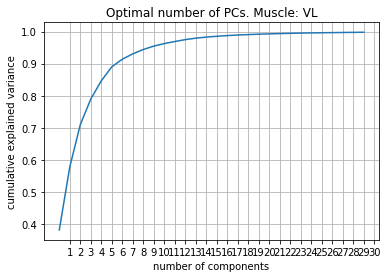

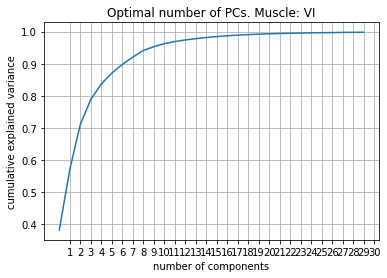

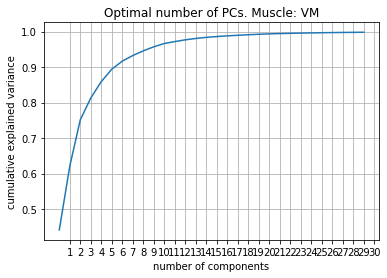

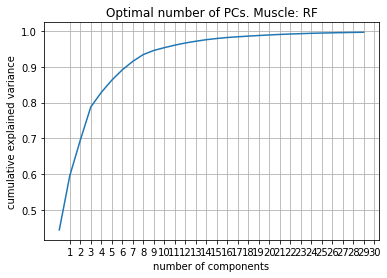

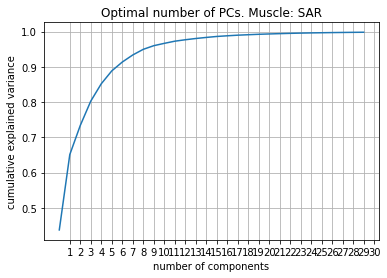

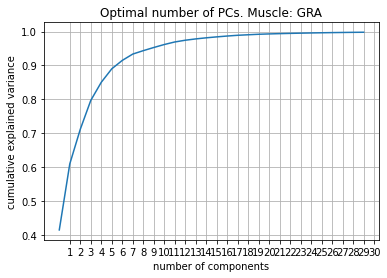

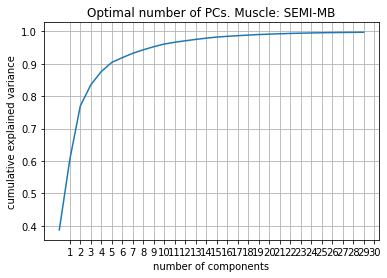

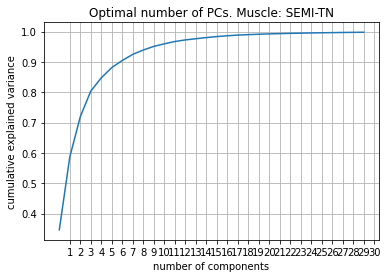

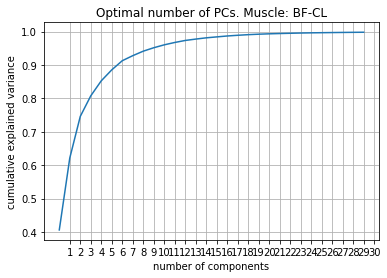

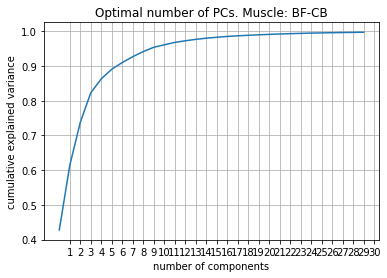

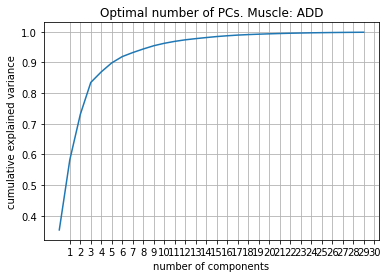

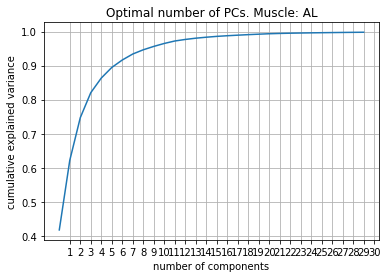

In [ ]:

y = np.arange(1,31)
#y = np.arange(1,6)

for df,path in zip(df_list,df_paths):
  label = os.path.splitext(path)[0].split('_')[1]

  data_subset = df[feature_names].values
  #data_subset_scaled = StandardScaler().fit_transform(data_subset)
  data_subset_scaled = MinMaxScaler().fit_transform(data_subset)

  pca = PCA(n_components = 30).fit(data_subset_scaled)

  plt.plot(np.cumsum(pca.explained_variance_ratio_))
  plt.xticks(y)
  plt.title('Optimal number of PCs. Muscle: {}'.format(label))
  plt.xlabel('number of components')
  plt.ylabel('cumulative explained variance')
  plt.grid()
  plt.show()



# Dai grafici riportati sopra, si può vedere che 3 dimensioni sono sufficienti per semplificare la rappresentazione del nostro insieme di features mantenendo  un'elevata quantità di informazioni. 
**Ma delle 86 features di partenza, quali sono le più rappresentative?**

> Ogni principal component è ottenuta dalla combinazione lineare di tutte le features
iniziali moltiplicate per un "peso" (che non è altro che il coefficiente di correlazione tra la feature originale e la principal component [1]). Quindi,le features più rappresentative,
saranno quelle che "pesano" di più.

> Per ricavarle , estraiamo gli autovettori corrispondenti alle nostre PC con la funzione pca.components_

[1] [https://www.jcchouinard.com/pca-with-python/#How_the_PCA_Machine_Learning_Algorithm_Works](https://)

**3D**

In [ ]:

#%%=============================================================================
#                   FEATURES PIU' RAPPRESENTATIVE E PCA
#===============================================================================
#FEATURES PIU' RILEVANTI =! PRINCIPAL COMPONENTS

#Features rilevanti --> sono un sottoinsieme delle features di partenza e sono semplicemente quelle che pesano 
#                       maggiormente nella combinazione lineare per ottenere PCi
#Principal components --> il loro numero lo decidiamo noi e permettono di rappresentare in maniera più semplice i dati
#                         ottimizzando la combinazione delle features di partenza in modo da mantenere la maggior
#                         parte delle informazioni iniziali.

relevant_features_PC1 = {}
relevant_features_PC2 = {}
relevant_features_PC3 = {}


pca_results_list = []


for df,path in zip(df_list,df_paths):
  label = os.path.splitext(path)[0].split('_')[1]
  print(label)

  data_subset = df[feature_names].values
  #data_subset_scaled = StandardScaler().fit_transform(data_subset)
  data_subset_scaled = MinMaxScaler().fit_transform(data_subset)   #normalizzo le variabili perchè PCA risente della scala. 
  
  pca = PCA(n_components = 3)
  pca_results_3d = pca.fit_transform(data_subset_scaled)   #ottengo 3 principal components
  pca_results_list.append(pca_results_3d)
  #-----------------Organizzazione utile per le relevant components-------------
  pca_df = pd.DataFrame(
    data=pca_results_3d, 
    columns=['PC1', 'PC2', 'PC3'])
  pca_df['Class'] = df['Class']
  # Principal components correlation coefficients
  loadings = pca.components_   #coefficienti autovettori
 
  # Number of features before PCA
  n_features = pca.n_features_
 
  # PC names
  pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]
 
  # Match PC names to loadings
  pc_loadings = dict(zip(pc_list, loadings))
 
  # Dataframe con features e rispettivi pesi per ogni PC
  loadings_df = pd.DataFrame.from_dict(pc_loadings)
  loadings_df['feature_names'] = feature_names
  loadings_df = loadings_df.set_index('feature_names')

  #per ogni dataframe (relativo ad un muscolo) estraggo le features più rilevanti e le metto nel dict
  #Criterio di estrazione:
  #considero il peso massimo (max(loadings_df['PCi']))
  #estraggo tutte le features associate ai pesi più elevati (ovvero maggiori di (peso_massimo - delta_piccolo))
  relevant_features_PC1[label] =  loadings_df.loc[loadings_df['PC1']>max(loadings_df['PC1'])-0.05,['PC1']]
  relevant_features_PC2[label] =  loadings_df.loc[loadings_df['PC2']>max(loadings_df['PC2'])-0.05,['PC2']]
  relevant_features_PC3[label] =  loadings_df.loc[loadings_df['PC3']>max(loadings_df['PC3'])-0.05,['PC3']]
  #-----------------------------------------------------------------------------

  #da 86 features passo a 3 principal components. Quanta informazione perdo? --> explained_variance_ratio_
  print('PCA 3 components explained variance : ',pca.explained_variance_ratio_)
  print('Cumulative explained variation for 3 principal components: ',np.sum(pca.explained_variance_ratio_)) 



VL
PCA 3 components explained variance :  [0.38205717 0.19636659 0.13132931]
Cumulative explained variation for 3 principal components:  0.7097530684679073
VI
PCA 3 components explained variance :  [0.38214081 0.18846117 0.1399568 ]
Cumulative explained variation for 3 principal components:  0.7105587811448201
VM
PCA 3 components explained variance :  [0.44128211 0.17983769 0.13020958]
Cumulative explained variation for 3 principal components:  0.7513293843900808
RF
PCA 3 components explained variance :  [0.44415811 0.15160427 0.09915091]
Cumulative explained variation for 3 principal components:  0.6949132952231014
SAR
PCA 3 components explained variance :  [0.43762936 0.21351755 0.08267136]
Cumulative explained variation for 3 principal components:  0.7338182681031991
GRA
PCA 3 components explained variance :  [0.41469244 0.19480284 0.1021286 ]
Cumulative explained variation for 3 principal components:  0.7116238804087853
SEMI-MB
PCA 3 components explained variance :  [0.38718826 0.2

In [ ]:
for i,muscle in enumerate(thigh_muscles):
  print(muscle)
  print(relevant_features_PC1[labels[i]])
  print('---------------------------------------------------')
  print('Number of most relevant features: ',relevant_features_PC1[labels[i]].shape[0])

Vasto Laterale
                                                      PC1
feature_names                                            
original_glcm_DifferenceAverage                  0.176191
original_glcm_DifferenceEntropy                  0.176146
original_glcm_Imc1                               0.205410
original_glrlm_RunLengthNonUniformityNormalized  0.193118
original_glrlm_RunPercentage                     0.219660
original_glrlm_ShortRunEmphasis                  0.189720
---------------------------------------------------
Number of most relevant features:  6
Vasto Intermedio
                                                      PC1
feature_names                                            
original_glcm_DifferenceEntropy                  0.173247
original_glcm_Imc1                               0.200116
original_gldm_DependenceNonUniformityNormalized  0.177389
original_glrlm_RunLengthNonUniformityNormalized  0.205983
original_glrlm_RunPercentage                     0.218490
original_

In [ ]:
for i,muscle in enumerate(thigh_muscles):
  print(muscle)
  print(relevant_features_PC2[labels[i]])
  print('---------------------------------------------------')
  print('Number of most relevant features: ',relevant_features_PC3[labels[i]].shape[0])

Vasto Laterale
                                                   PC2
feature_names                                         
original_firstorder_Entropy                   0.156885
original_glcm_SumEntropy                      0.153979
original_gldm_DependenceEntropy               0.160036
original_gldm_LowGrayLevelEmphasis            0.182653
original_glrlm_LowGrayLevelRunEmphasis        0.188684
original_glrlm_ShortRunLowGrayLevelEmphasis   0.192519
original_glszm_LowGrayLevelZoneEmphasis       0.174089
original_glszm_SmallAreaLowGrayLevelEmphasis  0.178333
---------------------------------------------------
Number of most relevant features:  9
Vasto Intermedio
                                                  PC2
feature_names                                        
original_firstorder_Entropy                  0.190459
original_firstorder_MeanAbsoluteDeviation    0.181497
original_firstorder_Variance                 0.169241
original_glcm_ClusterProminence              0.185209
origi

In [ ]:
for i,muscle in enumerate(thigh_muscles):
  print(muscle)
  print(relevant_features_PC3[labels[i]])
  print('---------------------------------------------------')
  print('Number of most relevant features: ',relevant_features_PC3[labels[i]].shape[0])

Vasto Laterale
                                                      PC3
feature_names                                            
original_firstorder_InterquartileRange           0.193984
original_firstorder_MeanAbsoluteDeviation        0.223854
original_firstorder_RobustMeanAbsoluteDeviation  0.197753
original_firstorder_Variance                     0.232710
original_glcm_ClusterProminence                  0.184848
original_glcm_ClusterTendency                    0.232704
original_glcm_SumSquares                         0.231943
original_gldm_GrayLevelVariance                  0.232782
original_glrlm_GrayLevelVariance                 0.221194
---------------------------------------------------
Number of most relevant features:  9
Vasto Intermedio
                                                         PC3
feature_names                                               
original_firstorder_90Percentile                    0.193934
original_firstorder_Kurtosis                        0.2267

In [ ]:
pca_results= {}
for results,path in zip(pca_results_list,df_paths):
  label = os.path.splitext(path)[0].split('_')[1]
  pca_results[label] = results


No outliers

In [ ]:
zoom_in_percentile_range = (0, 99)
df_plot_list = []
for df,label,muscle in zip(df_list,labels,thigh_muscles):
    X = pca_results[label]
    cutoffs_0 = np.percentile(X[:, 0], zoom_in_percentile_range)
    cutoffs_1 = np.percentile(X[:, 1], zoom_in_percentile_range)
    cutoffs_2 = np.percentile(X[:, 2], zoom_in_percentile_range)


    no_outliers_mask = np.all(X > [cutoffs_0[0], cutoffs_1[0], cutoffs_2[0]], axis=1) & np.all(
            X < [cutoffs_0[1], cutoffs_1[1], cutoffs_2[1]], axis=1)

    pca_results_no_outliers = X[no_outliers_mask]

    #creo un dataframe con pca_results_no_outliers e le classi corrispondenti

    df_plot = pd.DataFrame(pca_results_no_outliers,columns=['pca_3d_1','pca_3d_2','pca_3d_3'])
    df_plot['Class'] = (df['Class'].values)[no_outliers_mask]
    df_plot_list.append(df_plot)


#Visualizzazione escludendo gli outliers
codice

In [ ]:

for df_plot,muscle in zip(df_plot_list,thigh_muscles):
    fig = px.scatter_3d(
                df_plot, x= 'pca_3d_1', y= 'pca_3d_2', z= 'pca_3d_3',
                color= 'Class', labels={'color': 'Class'})
    fig.update_layout(legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01))
    fig.update_traces(marker_size=8)
    fig.update_layout(title= muscle, width=1400, height=500)

    fig.show()


#plots

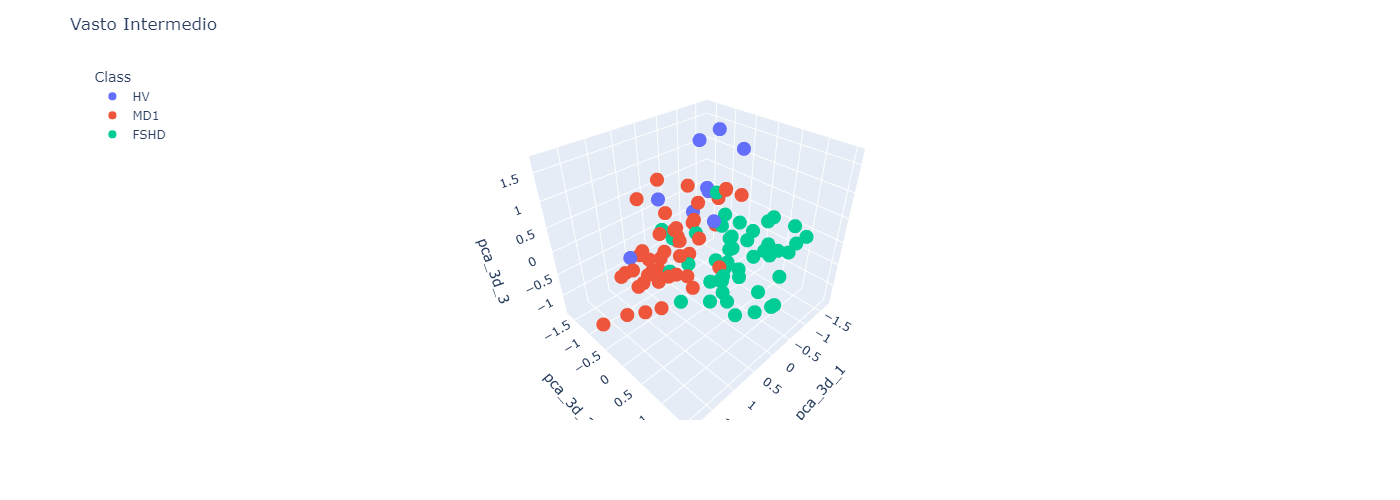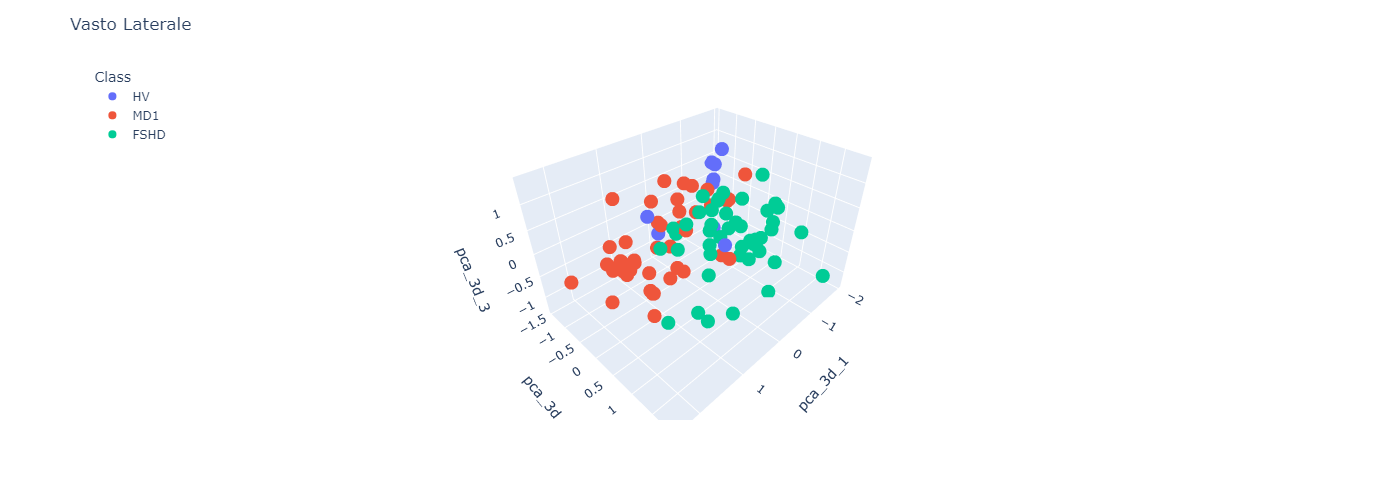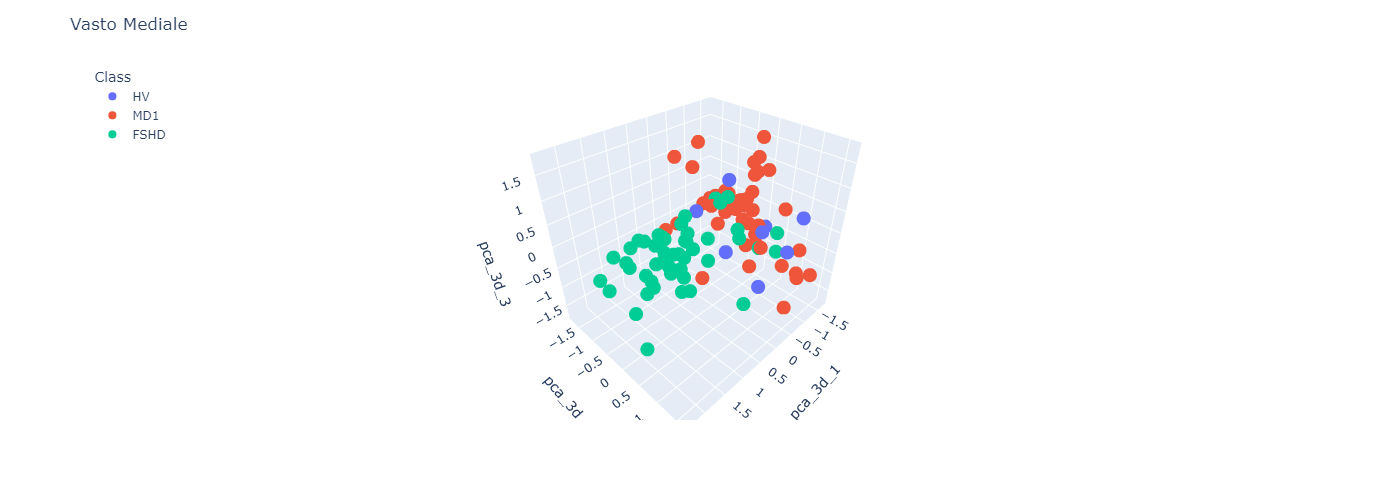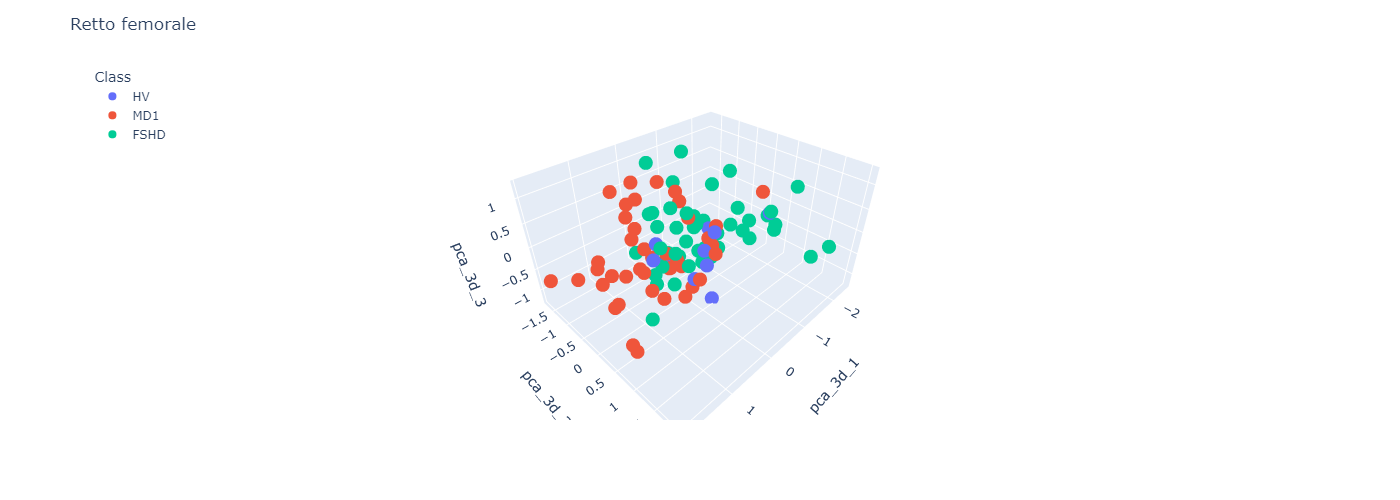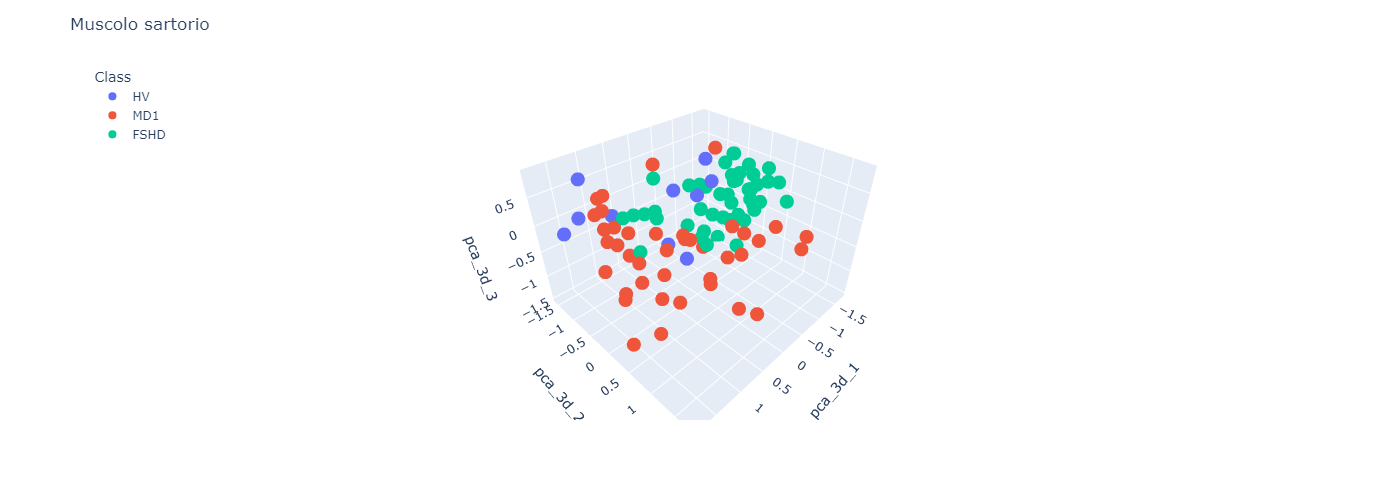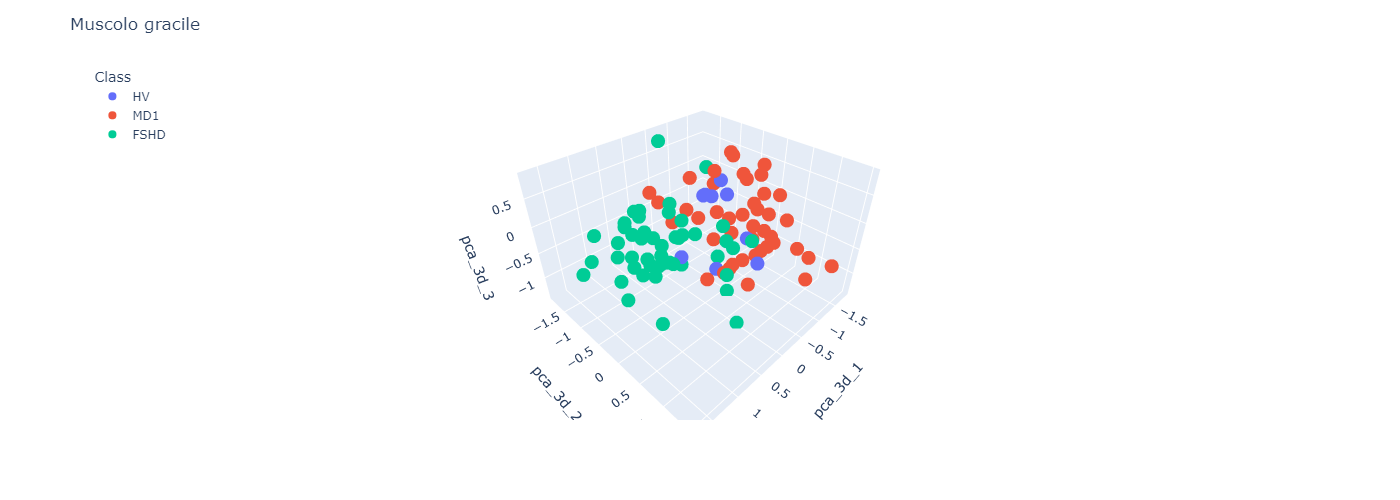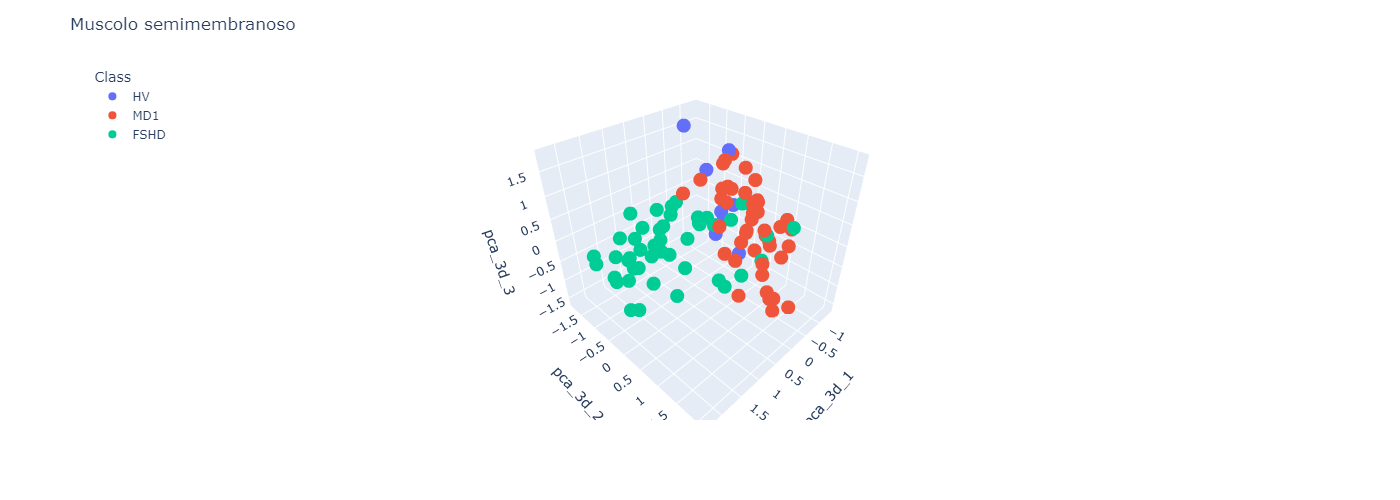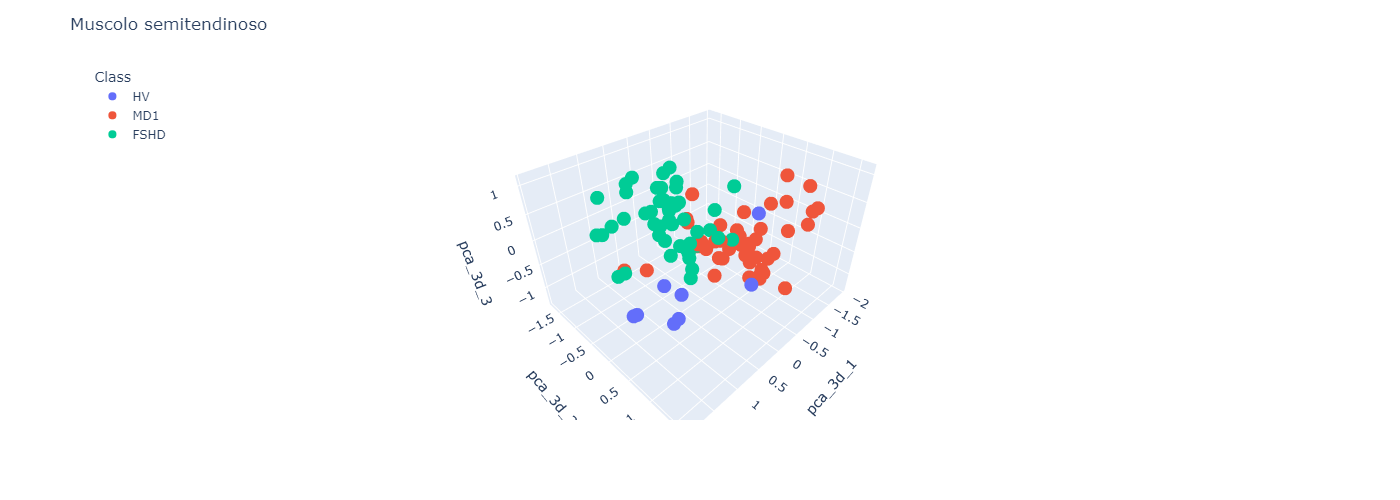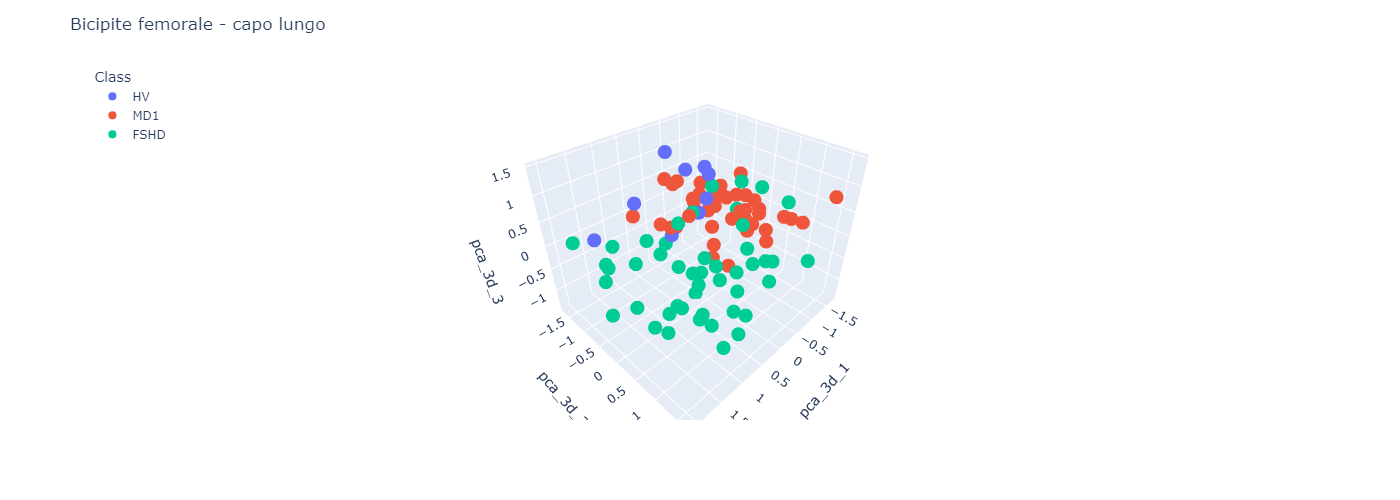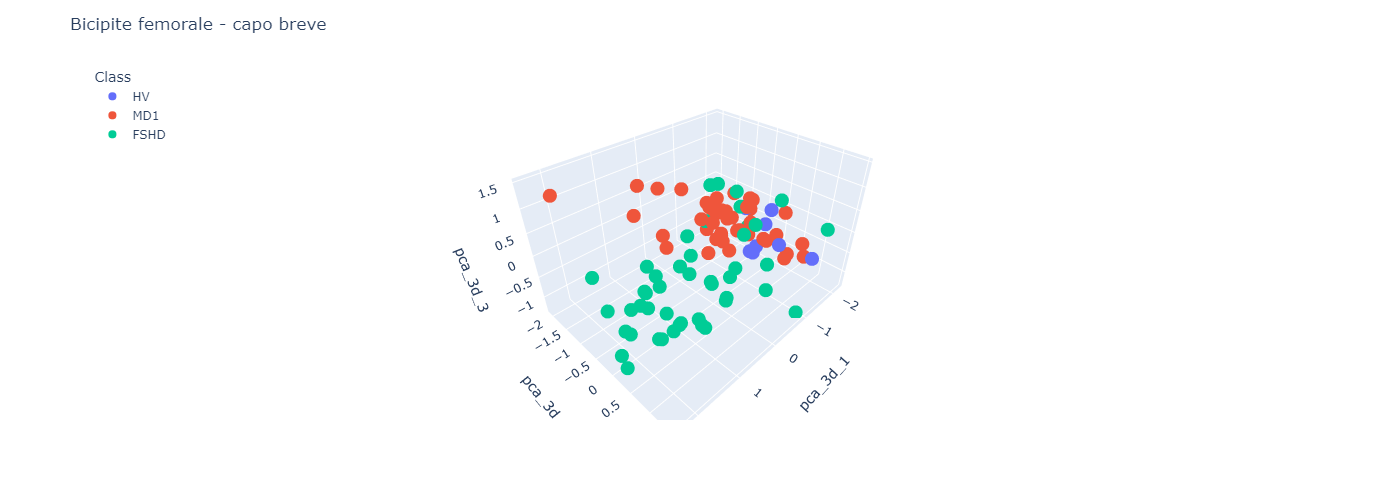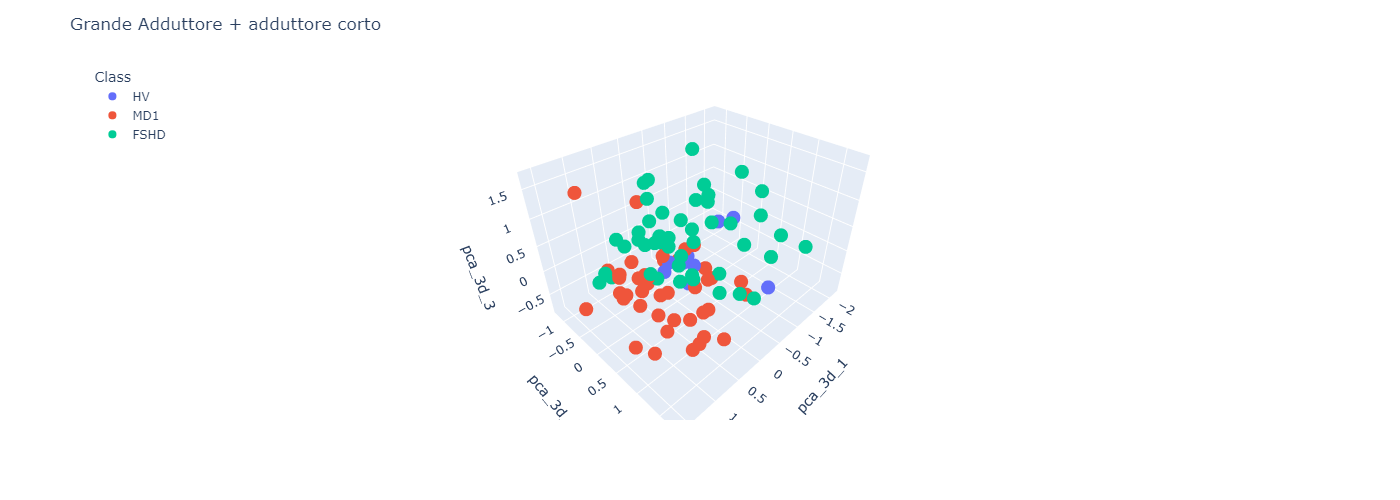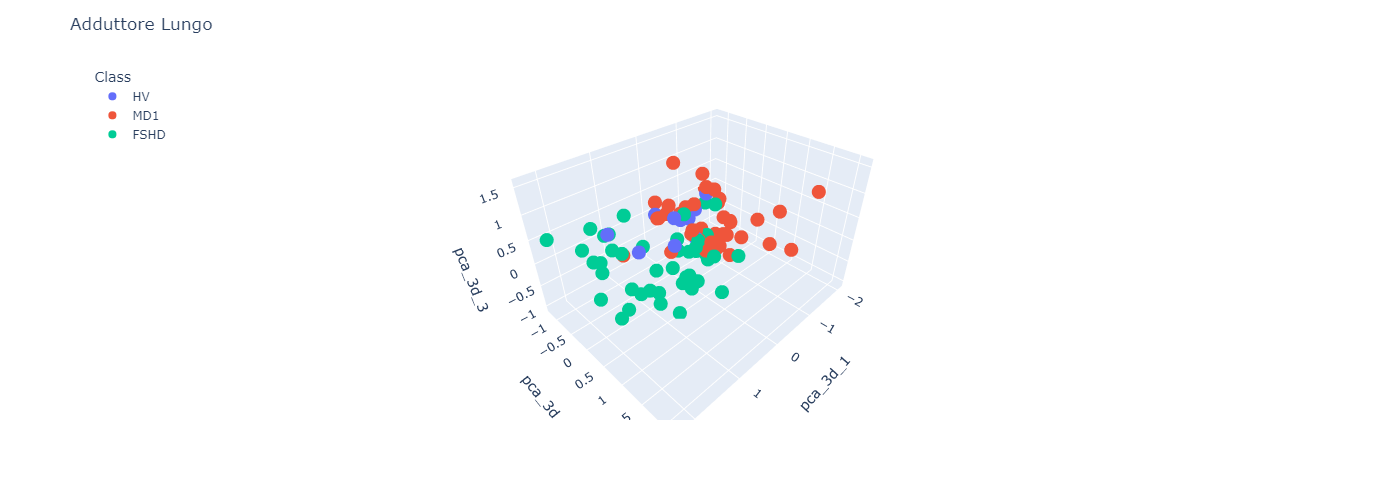

#Altre tecniche di dimensionality reduction
* t-SNE
* UMAP

**t-SNE**

In [ ]:
tsne_results = []

for df in df_list:
    
    data_subset= df[feature_names].values #estraggo solo le colonne "numeriche"
    data_subset_scaled = MinMaxScaler().fit_transform(data_subset)
    
    tsne = TSNE(n_components=3, random_state=0, verbose=0, perplexity=40, n_iter=1000)
    tsne_res = tsne.fit_transform(data_subset_scaled)
    print('t-SNE done!')
    tsne_results.append(tsne_res)

#VISUALIZZAZIONE

for df,result,muscle in zip(df_list,tsne_results,thigh_muscles):
    fig = px.scatter_3d(
        result, x= 0, y= 1, z= 2,
        color= df.Class, color_discrete_sequence= px.colors.qualitative.D3, labels={'color': 'Class'})
    fig.update_layout(legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01))
    fig.update_traces(marker_size=8)
    fig.update_layout(title= muscle, width=1400, height=500)

    fig.show()


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done!


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done!


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done!


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done!


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done!


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done!


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done!


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done!


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done!


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done!


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done!


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



t-SNE done!


**UMAP**

In [ ]:
umap_results = []

for df in df_list:
    
    data_subset= df[feature_names].values #estraggo solo le colonne "numeriche"
    data_subset_scaled = MinMaxScaler().fit_transform(data_subset)
    
    umap = UMAP(n_neighbors=20,min_dist=0.1,n_components=3,metric="euclidean")
    umap_res = umap.fit_transform(data_subset_scaled)
    print('UMAP done!')
    umap_results.append(umap_res)

#VISUALIZZAZIONE

for df,result,muscle in zip(df_list,umap_results,thigh_muscles):
    fig = px.scatter_3d(
        result, x= 0, y= 1, z= 2,
        color= df.Class, color_discrete_sequence=px.colors.qualitative.Safe, labels={'color': 'Class'})
    fig.update_layout(legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01))
    fig.update_traces(marker_size=8)
    fig.update_layout(title= muscle, width=1400, height=500)
    fig.show()


UMAP done!
UMAP done!
UMAP done!
UMAP done!
UMAP done!
UMAP done!
UMAP done!
UMAP done!
UMAP done!
UMAP done!
UMAP done!
UMAP done!
